# TFRecord Conversion

Initial Tensorflow model testing demonstrated that loading data was a bottleneck during the training process. This was inferred from the low GPU utilization throughout training. To help decrease load time, the current notebook:

* Resizes images.
* Converts the image data into a binary sequence.
* Saves the binary sequence in a single TFRecord file.

-----

## Imports

In [1]:
# Record Generation
from multiprocessing import Manager, Pool, cpu_count
import os
from TFRecord_generation import worker

# Testing
import tensorflow as TF
import numpy as NP
from matplotlib.pyplot import imshow, show
import random

# Augmentation Implmentation
from spec_augment import initialize_augmentation

----

## Constants

In [2]:
# Spectrogram & Record Directories
SPECTROGRAMS = 'D:/Spectrograms'
RECORDS = 'D:/Spectrogram_Records'

# Desired Image Sizes
SIZES = [(2480, 1232), (1240, 616), (620, 313), (1240, 313)]

----

## Conversion Algorithm

In [ ]:
if __name__ == '__main__':
    # Creating Record Directory
    if not os.path.exists(RECORDS):
        os.mkdir(RECORDS)

    # Initializing Worker Count & Shared Queue
    N_WORKERS = cpu_count() - 1
    queue = Manager().Queue()

    # Adding all desired jobs to queue.
    for spectrogram in os.listdir(SPECTROGRAMS):
        spectrogram_dir = os.path.join(SPECTROGRAMS, spectrogram)
        record = os.path.join(RECORDS, spectrogram)

        for size in SIZES:
            queue.put((spectrogram_dir, record, size, True))
            queue.put((spectrogram_dir, record, size, False))
            
    # Creating worker processes to exeucute the desired jobs.
    with Pool(processes = N_WORKERS) as pool:
        pool.map(worker, ([queue] * N_WORKERS))

----

## Testing

### Dataset Generation

In [3]:
# TFRecord Parser
feature_structure = {
    'image': TF.io.FixedLenFeature([], TF.string),
    'label': TF.io.FixedLenFeature([], TF.int64)
}
def parse_dataset(feature):
        data = TF.io.parse_single_example(feature, feature_structure)
        image = TF.io.decode_png(data['image'])
        return image, data['label']
        

# Dataset Generator
def generate_dataset(record = None):
    if record is None:
        record = os.path.join(RECORDS, random.choice(os.listdir(RECORDS)))
        
    raw_dataset = TF.data.TFRecordDataset(record).shuffle(100)
    dataset = raw_dataset.map(parse_dataset)
    
    return dataset

### Image Check

 - 3 - 
(313, 1240, 3)


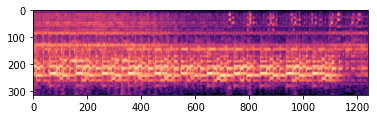

 - 12 - 
(313, 1240, 3)


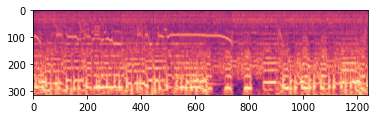

 - 12 - 
(313, 1240, 3)


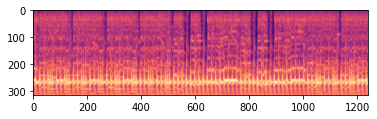

 - 12 - 
(313, 1240, 3)


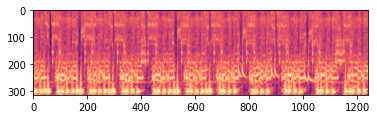

In [4]:
count = 0
dataset = iter(generate_dataset())

# Printing Samples
for image, label in generate_dataset():    
    print(f' - {label} - ')
    print(image.shape)
    imshow(NP.asarray(image))
    show()
    
    # Stop Counter
    count += 1
    if count == 4:
        break

### Augmentation Code Check

tf.Tensor(5, shape=(), dtype=int64)


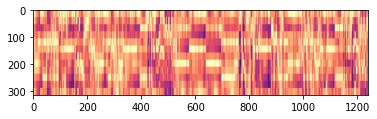

(313, 1240, 3)


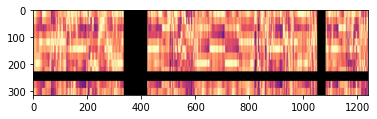

In [6]:
# Retrieving a random image & label.
dataset = iter(generate_dataset())
image, label = dataset.next()

# Printing original image & label.
print(label)
imshow(NP.asarray(image))
show()

# Retrieving augmented image.
spectrogram_augmentation = initialize_augmentation((image.shape[1], image.shape[0]), True)  
image = spectrogram_augmentation(TF.cast(image, TF.float32))
image = NP.asarray(image).astype(NP.uint8)

# Printing augmented image & shape.
print(image.shape)
imshow(image)
show()

del image